Fold 1
Epoch [1/200], Train Loss: 0.0756, Val Loss: 0.0112, Val MAE: 0.0752, Val RMSE: 0.0946, Val SMAPE: 101.68%
Epoch [2/200], Train Loss: 0.0546, Val Loss: 0.0107, Val MAE: 0.0857, Val RMSE: 0.1035, Val SMAPE: 80.89%
Epoch [3/200], Train Loss: 0.0310, Val Loss: 0.0287, Val MAE: 0.1625, Val RMSE: 0.1788, Val SMAPE: 103.72%
Epoch [4/200], Train Loss: 0.0192, Val Loss: 0.0304, Val MAE: 0.1758, Val RMSE: 0.1842, Val SMAPE: 109.20%
Epoch [5/200], Train Loss: 0.0155, Val Loss: 0.0140, Val MAE: 0.1130, Val RMSE: 0.1261, Val SMAPE: 90.58%
Epoch [6/200], Train Loss: 0.0125, Val Loss: 0.0096, Val MAE: 0.0935, Val RMSE: 0.1048, Val SMAPE: 84.03%
Epoch [7/200], Train Loss: 0.0085, Val Loss: 0.0070, Val MAE: 0.0797, Val RMSE: 0.0898, Val SMAPE: 78.65%
Epoch [8/200], Train Loss: 0.0053, Val Loss: 0.0033, Val MAE: 0.0503, Val RMSE: 0.0590, Val SMAPE: 62.69%
Epoch [9/200], Train Loss: 0.0038, Val Loss: 0.0035, Val MAE: 0.0451, Val RMSE: 0.0551, Val SMAPE: 65.92%
Epoch [10/200], Train Loss: 0.0039, 

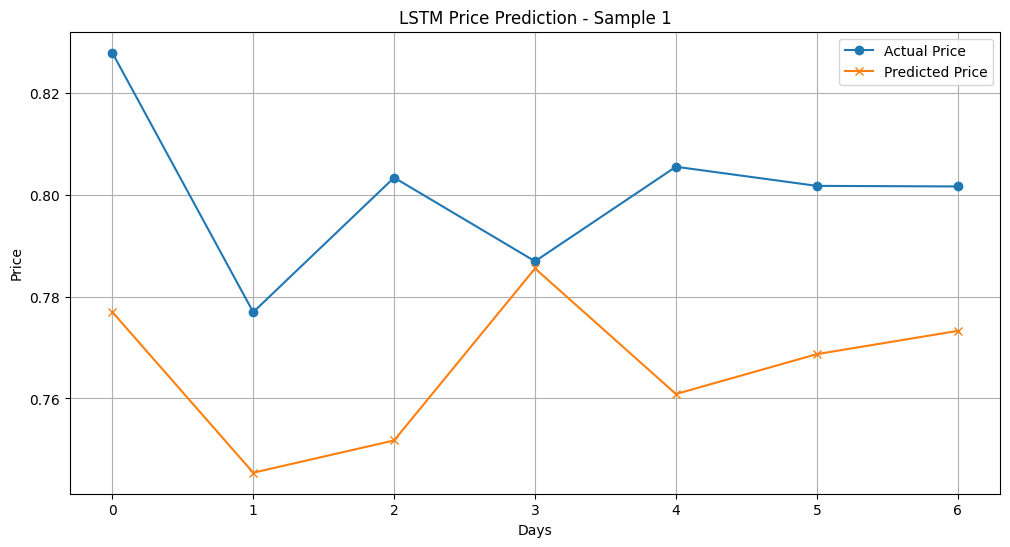

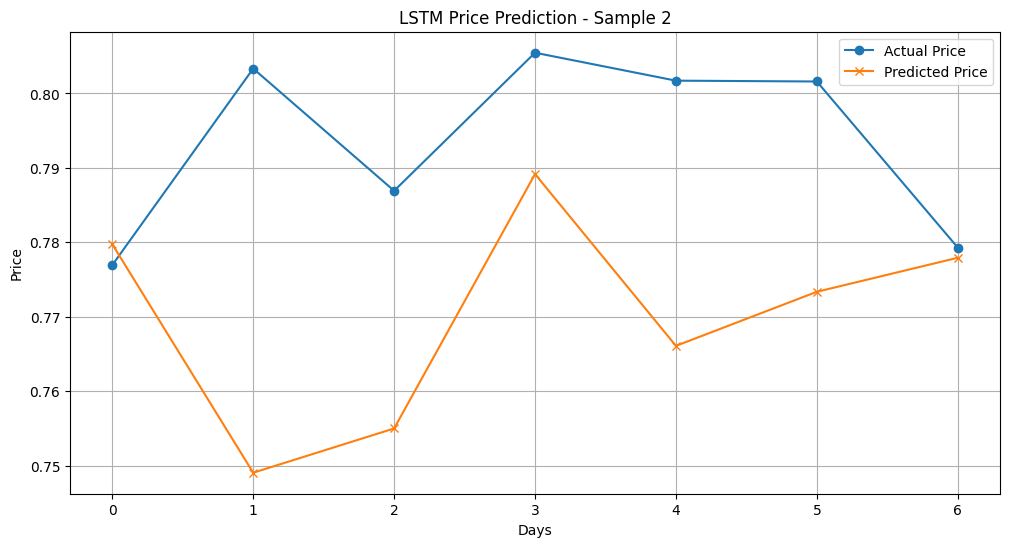

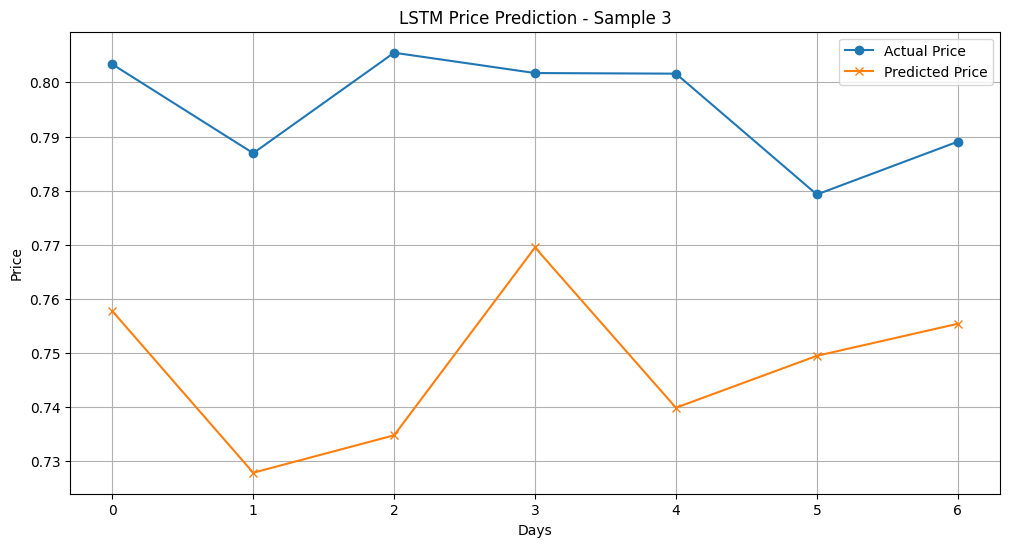

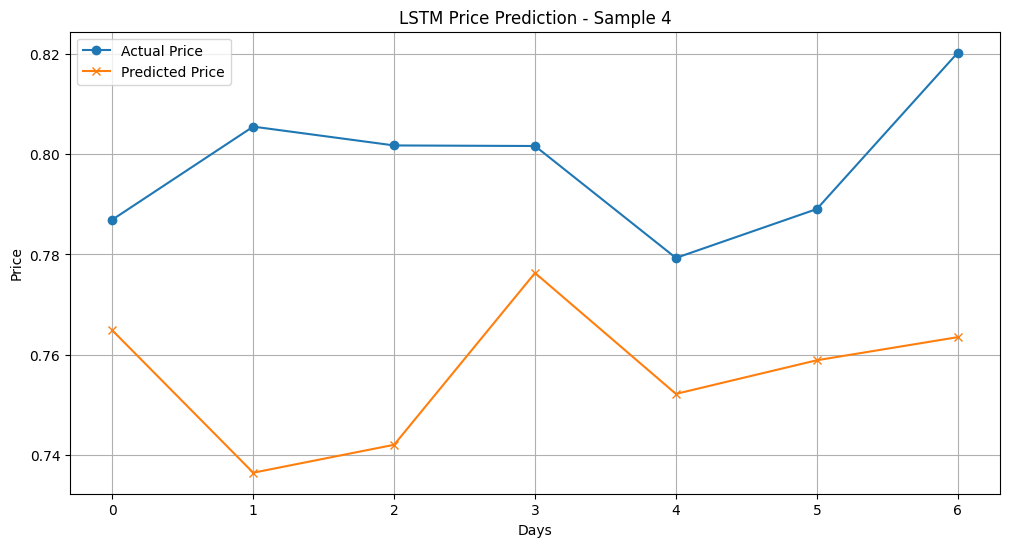

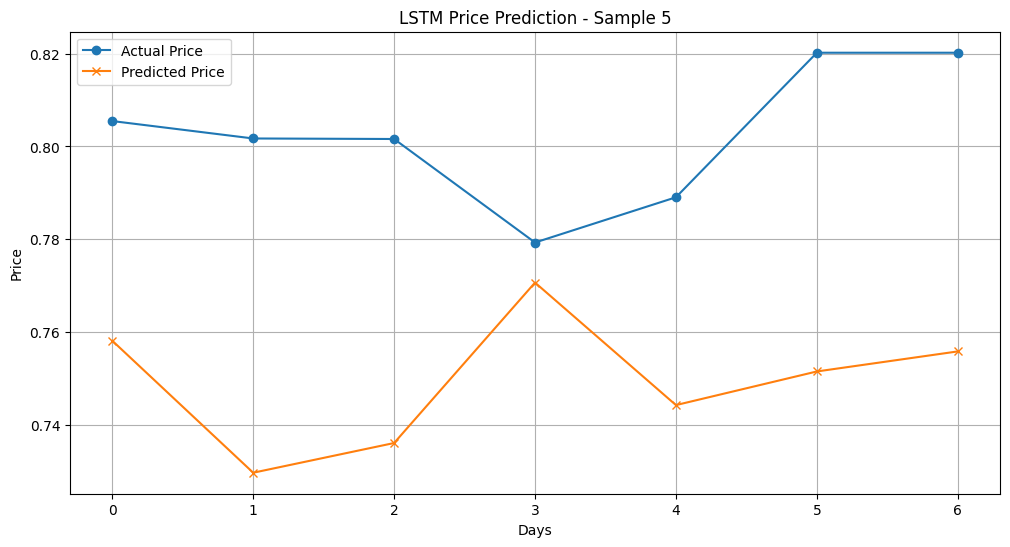

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def prepare_data(file_path, sequence_length=30, prediction_window=7, step=1):
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df = df.sort_values('Date')

    features = ['Open', 'High', 'Low', 'Close_lag_7', 'Close_lag_14',
                'Close_rolling_7', 'Close_rolling_14', 'MA(7)', 'MA(25)', 'MA(99)',
                'RSI', 'Vol(USDT)', 'Ensemble_Sentiment', 'Sentiment_7day_MA',
                'Sentiment_Change', 'Sentiment_Volatility']
    target = 'Close'

    # Add more technical indicators
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']

    features += ['EMA12', 'EMA26', 'MACD', 'Signal_Line', 'MACD_Histogram']

    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    df[features] = scaler_features.fit_transform(df[features])
    df[target] = scaler_target.fit_transform(df[[target]])

    X, y = [], []
    for i in range(0, len(df) - sequence_length - prediction_window + 1, step):
        X.append(df[features].iloc[i:i+sequence_length].values)
        y.append(df[target].iloc[i+sequence_length:i+sequence_length+prediction_window].values)

    X = np.array(X)
    y = np.array(y)

    return torch.FloatTensor(X), torch.FloatTensor(y), scaler_features, scaler_target

def train_model(model, train_loader, val_loader, scaler_target, epochs=100, lr=0.001, patience=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss, val_mae, val_rmse, val_smape = evaluate_model(model, val_loader, scaler_target, criterion)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}, Val SMAPE: {val_smape:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_lstm_model.pth')
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8))            
            
def evaluate_model(model, data_loader, scaler_target, criterion):
    model.eval()
    total_loss = 0
    true_values = []
    predictions = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            true_values.append(batch_y.numpy())
            predictions.append(outputs.numpy())
    
    true_values = np.concatenate(true_values)
    predictions = np.concatenate(predictions)
    
    # Inverse transform to get actual values
    true_values = scaler_target.inverse_transform(true_values)
    predictions = scaler_target.inverse_transform(predictions)
    
    # Calculate metrics
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    smape_value = smape(true_values, predictions)
    
    return total_loss / len(data_loader), mae, rmse, smape_value

def k_fold_cross_validation(X, y, model_class, n_splits=5, epochs=100, lr=0.001, patience=10, batch_size=64):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_metrics = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        print(f"Fold {fold}")

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        input_dim = X_train.shape[2]
        model = model_class(input_dim=input_dim, hidden_dim=64, num_layers=2, output_dim=prediction_window)

        train_model(model, train_loader, val_loader, scaler_target, epochs=epochs, lr=lr, patience=patience)

        # Evaluate the model
        _, mae, rmse, smape_value = evaluate_model(model, val_loader, scaler_target, nn.MSELoss())
        fold_metrics.append((mae, rmse, smape_value))

        print(f"Fold {fold} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, SMAPE: {smape_value:.2f}%")

    # Calculate average metrics
    avg_mae = np.mean([m[0] for m in fold_metrics])
    avg_rmse = np.mean([m[1] for m in fold_metrics])
    avg_smape = np.mean([m[2] for m in fold_metrics])

    print(f"\nAverage Metrics:")
    print(f"MAE: {avg_mae:.4f}")
    print(f"RMSE: {avg_rmse:.4f}")
    print(f"SMAPE: {avg_smape:.2f}%")

    return fold_metrics

def plot_predictions(actual, predicted, title='Cryptocurrency Price Prediction'):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Price', marker='o')
    plt.plot(predicted, label='Predicted Price', marker='x')
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
file_path = '/kaggle/input/dataset/processed_dataset.csv'
sequence_length = 30
prediction_window = 7
step = 1
batch_size = 64

X, y, scaler_features, scaler_target = prepare_data(file_path, sequence_length, prediction_window, step)

# Perform k-fold cross validation
fold_metrics = k_fold_cross_validation(X, y, LSTMModel, n_splits=3, epochs=200, lr=0.001, patience=20, batch_size=64)

# Use the best model for predictions
best_fold = np.argmin([m[0] for m in fold_metrics])
best_model = LSTMModel(input_dim=X.shape[2], hidden_dim=64, num_layers=2, output_dim=prediction_window)
best_model.load_state_dict(torch.load('best_lstm_model.pth'))

# Make predictions and convert to actual prices
sample_X = X[-5:]  # Get the last 5 samples
with torch.no_grad():
    predictions = best_model(sample_X)

original_predictions = scaler_target.inverse_transform(predictions.numpy())
original_y = scaler_target.inverse_transform(y[-5:].numpy())

print("Some predictions:", original_predictions)
print("Corresponding actual prices:", original_y)

# Plot predictions
for i in range(len(original_y)):
    plot_predictions(original_y[i], original_predictions[i], f'LSTM Price Prediction - Sample {i+1}')